# Word in Context (WiC) Classification Assignment

**Please pay attention to these notes:**
<br><br>

- The coding parts you need to implement are denoted by:
```
    #################################
    ## PUT YOU IMPLEMENTATION HERE ##
    #################################
```

- You must run this notebook on Google Colab platform, it depends on Google Colab VM for some of the depencecies. <b><font color='red'> You must also use the GPU runtime for faster training of the model. </font></b>
- <b><font color='red'>When you are ready to submit, please follow the instructions at the end of this notebook.</font></b>

<br>

--------------------------------------------------

In this assignment, you will implement a classifier that determines whether a word has the same meaning in two different sentences. You'll be using the WiC (Word in Context) dataset and BERT embeddings to solve this task.

First lets install the requirements:

In [ ]:
#importing clear_output() function from notebook utilities
from IPython.display import clear_output

!pip install datasets

clear_output()
print('Done!')

Done!


## Dataset Description

The WiC dataset provides pairs of sentences where a target word appears in both sentences. Your task is to determine whether the word is used with the same sense (meaning) in both sentences. For example:

```
Sentence 1: "The house has a nice room."
Sentence 2: "There's not enough room for everyone."
Target word: "room"
Label: 0 (different meaning)
```

Each example in the dataset contains:
- `sentence1`: First sentence
- `sentence2`: Second sentence
- `word`: The target word
- `start1`  , `end1`: Character positions of the target word in sentence1
- `start2`  , `end2`: Character positions of the target word in sentence2
- `label`: 1 if the word has the same meaning in both sentences, 0 otherwise


In [ ]:
# ==================================================================================
#                    COPY THIS CELL INTO THE ASSIGNMENT NOTEBOOK                   #
# ==================================================================================

from IPython.display import clear_output


# we download the files of the full dataset from here
!pip install gdown
!gdown --folder https://drive.google.com/drive/folders/1ZFz8-p40Ywoe8oBHb6H8ihO-boQqiq6_ -O /content/

!pip install datasets

# Lets take a look!

from datasets import load_dataset
from pprint import pprint

# Load dataset

####### WARNING! The Hugging Face version of the dataset does not include the test labels.
####### However, you can obtain the full dataset by running the following script.
####### Be sure to execute the previous cell first.

dataset = load_dataset('./WiC/wic_loader.py',
                        data_dir='./WiC',
                        trust_remote_code=True)




# Clear the output
clear_output()

print('The dataset blueprint is: ')
print(dataset)
print("============")
print('The first example of the train partition is: ')
pprint(dataset['train'][0])

The dataset blueprint is: 
DatasetDict({
    train: Dataset({
        features: ['word', 'sentence1', 'sentence2', 'start1', 'start2', 'end1', 'end2', 'idx', 'label'],
        num_rows: 5428
    })
    validation: Dataset({
        features: ['word', 'sentence1', 'sentence2', 'start1', 'start2', 'end1', 'end2', 'idx', 'label'],
        num_rows: 638
    })
    test: Dataset({
        features: ['word', 'sentence1', 'sentence2', 'start1', 'start2', 'end1', 'end2', 'idx', 'label'],
        num_rows: 1400
    })
})
The first example of the train partition is: 
{'end1': 14,
 'end2': 13,
 'idx': 0,
 'label': 0,
 'sentence1': 'You must carry your camping gear .',
 'sentence2': 'Sound carries well over water .',
 'start1': 9,
 'start2': 6,
 'word': 'carry'}


## How to approach the problem?

To address this problem, we need a vector representation (embedding) of the target word in each of the two sentences. To achieve this, we first pass each sentence through the BERT model separately to obtain token embeddings. Next, we identify the sub-tokens corresponding to the target word in each sentence and compute their average embedding to represent the target word. Finally, we concatenate the two resulting vectors and feed them into a classifier, which determines whether the words share the same meaning based on these embeddings.

In order to identify the sub-tokens corresponding to the target word, you should implement the `find_target_token_indices` function (similar to what we had in the class), which takes three inputs:

- `start_idx`: The starting character index of the target word.
- `end_idx`: The ending character index of the target word.
- `offset_mapping`: A tensor containing character spans for each token in a tokenized sentence.

The function should return a binary mask indicating which tokens correspond to the target word. To achieve this, iterate through offset_mapping and check if each token’s character span overlaps with the target word’s span (start_idx to end_idx). If there is an overlap, mark that token’s index in the mask as 1; otherwise, keep it 0. Finally, return the binary mask.


Here is an example usage:

```python
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    
    sentence = "working with tokenizer is fun!."
    target_word = "tokenizer"
    start_idx = sentence.index(target_word)  # = 13
    end_idx = start_idx + len(target_word) # = 22
    
    encoding = tokenizer(sentence, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding["offset_mapping"][0] # get the first item to remove the tokenizer's batching
    input_ids = encoding["input_ids"][0] # get the first item to remove the tokenizer's batching

    mask = find_target_token_indices(start_idx, end_idx, offset_mapping)

    print((tokenizer.convert_ids_to_tokens(input_ids)))
   # >>> ['[CLS]', 'working', 'with', 'token', '##izer', 'is', 'fun', '!', '[SEP]']

    print(mask)
    # >>> tensor([0., 0., 0., 1., 1., 0., 0., 0., 0.])
```



In [ ]:
import torch

def find_target_token_indices(start_idx, end_idx, offset_mapping):
    """
    Find token indices for a specific target word using offset mapping.

    Args:
        start_idx (int): Character start index of target word
        end_idx (int): Character end index of target word
        offset_mapping (torch.Tensor): Offset mapping from tokenization of the sentence

    Returns:
        torch.Tensor: Binary mask for target word tokens
    """
    # Initialize a mask of zeros with the same length as offset_mapping
    mask = torch.zeros(offset_mapping.shape[0], dtype=torch.float)

    # Iterate through token offsets to find matching tokens
    for i in range(offset_mapping.shape[0]):
        token_start, token_end = offset_mapping[i].tolist()  # Convert tensor to list for indexing

        # Check which tokens overlap with the target word
        if (token_start < end_idx) and (token_end > start_idx):
            mask[i] = 1.0
    return mask

Test you implementation!

Note: In this test, we remove the tokenizer's batching behavior when extracting `input_ids` and `offset_mapping` by selecting the first item (index `0`). Otherwise, the output would have two dimensions, with the first dimension that represents the batch always having a single item (length of 1), which is redundant since we only process a single sentence at a time (i.e., a batch size of one).

In [ ]:
from transformers import AutoTokenizer

# Loading the Tokenizer:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Test case: Basic word detection
sentence = "Working with tokenizer is fun!"
target_word = "tokenizer"
start_idx = sentence.index(target_word)
end_idx = start_idx + len(target_word)
encoding = tokenizer(sentence, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding["offset_mapping"][0] # get the first item to remove the tokenizer's batching
input_ids = encoding["input_ids"][0] # get the first item to remove the tokenizer's batching

mask = find_target_token_indices(start_idx, end_idx, offset_mapping)

assert mask.shape == input_ids.shape, "Mask should have the same shape as input_ids"
assert mask.sum().item() > 0, "Target word indices should be masked"
assert (tokenizer.decode(input_ids[mask==1])) == "tokenizer", "Wrong word is masked!"

print("Simple test passed!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Simple test passed!


## WiCDataset class

The WiCDataset class implements a PyTorch Dataset for the Word-in-Context (WiC) task. It processes pairs of sentences where a target word appears in both, preparing the data for a model to determine if the word has the same meaning in both contexts.
The inputs are:

Inputs:
- `dataset` containing sentence pairs, target word indices, and labels;
- `tokenizer` : an instance of bert tokenizer;
- `max_length` : the max length parameter that we pass to the tokenizer when encoding a sentence.

When the `__getitem__` method is called, you should extract the sentence pairs, word indices, and labels for the dataset item at index `idx`. Then, tokenize both sentences with padding and truncation. Next, create target masks to highlight the word positions using the `find_target_token_indices` function you implemented earlier.  

Your output should be a dictionary containing the tokenized inputs, attention masks, target masks, the item label, and the target word.

Example usage:




```python
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dataset = dataset = load_dataset("super_glue", "wic",
                       trust_remote_code=True)
wic_dataset = WiCDataset(dataset["train"], tokenizer)

# Get first instance
sample = wic_dataset[0]

# Print original sentences
print("Sentence 1:", dataset["train"]["sentence1"][0])
print("Sentence 2:", dataset["train"]["sentence2"][0])
print("Target word:", sample["word"])
print("Label:", sample["label"])

# Print tokenized output
print("\nTokenized sentence 1:",
      tokenizer.convert_ids_to_tokens(sample["input_ids1"]))

# Show target word position
print("\nTarget mask 1:", sample["target_mask1"])
print("Target mask 2:", sample["target_mask2"])

# Check attention masks (1 for tokens, 0 for padding)
print("\nAttention mask 1:", sample["attention_mask1"])
```



In [ ]:
from torch.utils.data import Dataset
import torch

class WiCDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=128):
        """
        Initializes the WiC dataset.

        Args:
            dataset: Dataset containing sentence pairs, target word indices, and labels
            tokenizer: BERT Tokenizer
            max_length: Maximum token length for tokenization
        """
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)  # Return the size of the dataset

    def __getitem__(self, idx):
        """
        Retrieves and processes a single data instance from the dataset.

        Args:
            idx: Index of the data instance

        Returns:
            A dictionary containing tokenized input, target masks, and label for the instance.
        """
        # Extracting sentence pair, word, label, start and end indices
        item = self.dataset[idx]
        sentence1 = item['sentence1']
        sentence2 = item['sentence2']
        word = item['word']
        label = item['label']
        start1 = item['start1']
        end1 = item['end1']
        start2 = item['start2']
        end2 = item['end2']

        # Tokenize sentence1
        encoding1 = self.tokenizer(
            sentence1,
            max_length=self.max_length,
            padding='max_length',      # Pad the sentences to the max length
            truncation=True,           # Truncate if necessary
            return_offsets_mapping=True,
            return_tensors='pt'        # Return as PyTorch tensors
        )

        # Removing batch dimensions
        input_ids1 = encoding1['input_ids'].squeeze(0)
        attention_mask1 = encoding1['attention_mask'].squeeze(0)
        offset_mapping1 = encoding1['offset_mapping'].squeeze(0)
        target_mask1 = find_target_token_indices(start1, end1, offset_mapping1)  # Generate target mask for sentence1

        # Tokenize sentence2
        encoding2 = self.tokenizer(
            sentence2,
            max_length=self.max_length,
            padding='max_length',       # Pad the sentences to the max length
            truncation=True,            # Truncate if necessary
            return_offsets_mapping=True,
            return_tensors='pt'         # Return as PyTorch tensors
        )

        # Removing batch dimensions
        input_ids2 = encoding2['input_ids'].squeeze(0)
        attention_mask2 = encoding2['attention_mask'].squeeze(0)
        offset_mapping2 = encoding2['offset_mapping'].squeeze(0)
        target_mask2 = find_target_token_indices(start2, end2, offset_mapping2)  # Generate target mask for sentence2

        # Return the processed data as a dictionary
        return {
            'input_ids1': input_ids1,
            'attention_mask1': attention_mask1,
            'input_ids2': input_ids2,
            'attention_mask2': attention_mask2,
            'target_mask1': target_mask1,
            'target_mask2': target_mask2,
            'label': torch.tensor(label, dtype=torch.long),  # Convert label to tensor
            'word': word     # Returns the target word
        }

Test your WiCDataset:

In [ ]:
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# A simple dataset to test
dataset_sample = dataset['train'].select(range(5))  # Select first 5 rows correctly

# Simple tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create DataLoader
dataset_instance = WiCDataset(dataset_sample, tokenizer, max_length=15)
dataloader = DataLoader(dataset_instance, batch_size=5, shuffle=False)

# Testing the first batch
batch = next(iter(dataloader))
print(batch)

assert tokenizer.convert_ids_to_tokens(batch['input_ids1'][batch['target_mask1']==1]) == batch['word'], 'Wrong words masked!'
print('Simple test passed!')

{'input_ids1': tensor([[  101,  2017,  2442,  4287,  2115, 13215,  6718,  1012,   102,     0,
             0,     0,     0,     0,     0],
        [  101,  7696,  2442,  2175,  2083,  8041,  6833,  1012,   102,     0,
             0,     0,     0,     0,     0],
        [  101,  3338,  2019,  4862,  5638,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2002,  5078,  1037, 23407, 16195,  2007,  1037,  3384,  2452,
          1012,   102,     0,     0,     0],
        [  101,  1996,  2914,  1997,  2189,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0]]), 'attention_mask1': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]), 'input_ids2': tensor([[  101,  2614,  7883,  2092,  2058,  2300,  1

## WiCClassifier torch module

To build a WiC classifier, create a PyTorch model that inherits from nn.Module. Your model should use a pre-trained BERT model to extract contextual embeddings and include a classifier for binary classification. The classifier should consist of a nn.Linear layer followed by a nn.ReLU activation. The input size of the linear layer should be 2 * bert_hidden_size (which is 768 for BERT, resulting in 1536), and the output size should be 2, equal to the number of our classes. The input size is doubled because the model concatenates two vectors of size 768—as we see later in `forward` method, each representing the target word embedding from one of the two sentences—before passing them to the classifier.

In the `__init__` method, store the BERT model as `self.bert`, and define the linear classifier with the appropriate input and output sizes and the relu activation function. After the linear layer, apply `nn.ReLU()` to introduce non-linearity and improve the model’s ability to capture complex patterns. You can stack different torch modules on top using `nn.Sequential` ([look at the PyTorch documentation for more details](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). This setup ensures that your model can effectively distinguish between the two classes.

The `forward` method should take six inputs: two sets of input IDs and attention masks, along with two target masks. First, pass these inputs through BERT to obtain the contextual embeddings for both sentences. Then, compute the target word representations using masked averaging: multiply the embeddings by the target mask to zero out the embeddings of subwords that do not belong to the target word, sum the remaining embeddings, and divide by the number of subword tokens of the target word. Finally, concatenate these average-pulled target word representations and pass the resulting vector through the classifier you initialized earlier to generate the prediction.

Note: At some point, you should be using the `unsqueeze()` method of torch tensors to ensure correct broadcasting (hint: when applying target masks to the extracted embeddings). Also, make sure that all operations maintain the batch dimension so that your model works correctly during training.

In [ ]:
import torch.nn as nn

class WiCClassifier(nn.Module):

    def __init__(self, bert_model):
        """
        Initialize the WiCClassifier model.

        Args:
            bert_model (nn.Module): Pre-trained BERT model for contextual embeddings
        """
        super().__init__()
        self.bert = bert_model

        # Defining a Classifier : Linear layer followed by ReLU activation
        self.classifier = nn.Sequential(
            nn.Linear(2 * 768, 2), # Input size: 2 * BERT hidden size (768), Output size: 2 (for binary classification)
            nn.ReLU()              # ReLU activation to introduce non-linearity to the model
        )

        """
        Shape of all the input tensors is > [batch_size, max_sequence_length]

        Args:
            input_ids1 (torch.Tensor): Tokenized input IDs for first sentence
            attention_mask1 (torch.Tensor): Attention mask for first sentence
            input_ids2 (torch.Tensor): Tokenized input IDs for second sentence
            attention_mask2 (torch.Tensor): Attention mask for second sentence
            target_mask1 (torch.Tensor): Binary mask highlighting target word tokens in first sentence
            target_mask2 (torch.Tensor): Binary mask highlighting target word tokens in second sentence

        Output:
            classification_logits (torch.Tensor): Logits for binary classification > Shape: [batch_size, 2]

        Workflow:
        1. Extract contextual embeddings for both sentences using BERT
        2. Compute target word representations by masked averaging
        3. Concatenate target word representations
        4. Classify using a linear layer
        """





    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, target_mask1, target_mask2):
        # Get embeddings for both sentences
        outputs1 = self.bert(input_ids1, attention_mask=attention_mask1)
        embeddings1 = outputs1.last_hidden_state   # Extract embeddings from the last hidden layer
        outputs2 = self.bert(input_ids2, attention_mask=attention_mask2)
        embeddings2 = outputs2.last_hidden_state   # Extract embeddings from the last hidden layer

        # Compute target word embeddings dor both sentences using masked average

        # Mask the embeddings by target word positions and sum the masked tokens
        target_mask1 = target_mask1.unsqueeze(-1) # Add an extra dimension for broadcasting
        masked_embeddings1 = embeddings1 * target_mask1  # Apply target mask to embeddings
        summed_embeddings1 = torch.sum(masked_embeddings1, dim=1) # Sum embeddings along sequence dimension
        sum_mask1 = torch.sum(target_mask1.squeeze(-1), dim=1, keepdim=True)  #Count the number of subword tokens
        avg_embeddings1 = summed_embeddings1 / sum_mask1.clamp(min=1e-9)      # Compute average by dividing by token count

        target_mask2 = target_mask2.unsqueeze(-1) # Add an extra dimension for broadcasting
        masked_embeddings2 = embeddings2 * target_mask2  # Apply target mask to embeddings
        summed_embeddings2 = torch.sum(masked_embeddings2, dim=1)  # Sum embeddings along sequence dimension
        sum_mask2 = torch.sum(target_mask2.squeeze(-1), dim=1, keepdim=True)  # Count the number of subword tokens
        avg_embeddings2 = summed_embeddings2 / sum_mask2.clamp(min=1e-9) # Compute avg by dividing by token count

        # Concatenate thee target word representations from both sentences
        combined = torch.cat([avg_embeddings1, avg_embeddings2], dim=1)

         # Pass the concatenated vector through the classifier to get logits
        logits = self.classifier(combined)  # Apply the linear layer with ReLU activation
        return logits


## Train the model

You can train your model using the following code:

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn as nn
from transformers import AutoModel

num_epochs = 3
learning_rate = 2e-5
max_length=128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_dataset = WiCDataset(dataset['train'], tokenizer, max_length)
val_dataset = WiCDataset(dataset['validation'], tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


bert_model = AutoModel.from_pretrained('bert-base-uncased')
model = WiCClassifier(bert_model)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader)
    for batch in progress_bar:
        input_ids1 = batch['input_ids1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        target_mask1 = batch['target_mask1'].to(device)
        target_mask2 = batch['target_mask2'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids1,
                        attention_mask1,
                        input_ids2,
                        attention_mask2,
                        target_mask1,
                        target_mask2)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({f"Loss": loss.item()})


    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:

            input_ids1 = batch['input_ids1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            attention_mask1 = batch['attention_mask1'].to(device)
            attention_mask2 = batch['attention_mask2'].to(device)
            target_mask1 = batch['target_mask1'].to(device)
            target_mask2 = batch['target_mask2'].to(device)
            labels = batch['label'].to(device)


            outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2, target_mask1, target_mask2)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} done!")
    print(f"Average training loss: {total_loss/len(train_loader):.4f}")
    print(f"Validation accuracy: {val_acc:.4f}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 170/170 [03:20<00:00,  1.18s/it, Loss=0.575]


Epoch 1/3 done!
Average training loss: 0.6705
Validation accuracy: 0.5627


100%|██████████| 170/170 [03:25<00:00,  1.21s/it, Loss=0.784]


Epoch 2/3 done!
Average training loss: 0.5434
Validation accuracy: 0.5690


100%|██████████| 170/170 [03:25<00:00,  1.21s/it, Loss=0.42]


Epoch 3/3 done!
Average training loss: 0.4069
Validation accuracy: 0.5768


The WiC dataset includes a test set, in addition to the train and validation sets. Write a code to evaluate your model on the test set of the WiC dataset and print out the accuracy, following a similar approach as we did in the training loop with the validation dataset.

In [ ]:
test_dataset = WiCDataset(dataset['test'], tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        # Move batch tensors to the same device as the model
        input_ids1 = batch['input_ids1'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        target_mask1 = batch['target_mask1'].to(device)
        target_mask2 = batch['target_mask2'].to(device)
        labels = batch['label'].to(device)

        # Get model predictions:
        outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2, target_mask1, target_mask2)

        # Get predicted class
        _, predicted = torch.max(outputs, 1)
        # Update correct count and total count
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print Test accuracy
print(f"Test Accuracy: {correct/total:.4f}")

Test Accuracy: 0.5507


## Improve your model

This section is all yours! Try exploring a different approach to solving this task. You could experiment with modifying the classifier architecture—for example, adding more linear layers instead of using just one. Additionally, consider adjusting the training hyperparameters, such as increasing the number of training epochs, to improve performance.

Go ahead and implement your new model and training loop. Your updated training loop should also record the loss at each iteration. Once training is complete, visualize the recorded training loss values by plotting them using a library like Matplotlib. You must also aim for a final test accuracy in the range of 65–70%.

Device set to use cuda
Training with Config 1 (r=10, lora_alpha=16)


Epoch 1/5: 100%|██████████| 170/170 [02:32<00:00,  1.11it/s]


Epoch 1/5 done! Average training loss: 0.6744
Validation accuracy for Config 1: 0.5972


Epoch 2/5: 100%|██████████| 170/170 [02:32<00:00,  1.12it/s]


Epoch 2/5 done! Average training loss: 0.6205
Validation accuracy for Config 1: 0.6395


Epoch 3/5: 100%|██████████| 170/170 [02:32<00:00,  1.12it/s]


Epoch 3/5 done! Average training loss: 0.5826
Validation accuracy for Config 1: 0.6254


Epoch 4/5: 100%|██████████| 170/170 [02:31<00:00,  1.12it/s]


Epoch 4/5 done! Average training loss: 0.5590
Validation accuracy for Config 1: 0.6301


Epoch 5/5: 100%|██████████| 170/170 [02:31<00:00,  1.12it/s]


Epoch 5/5 done! Average training loss: 0.5527
Validation accuracy for Config 1: 0.6254
Training with Config 2 (r=12, lora_alpha=15)


Epoch 1/5: 100%|██████████| 170/170 [02:31<00:00,  1.12it/s]


Epoch 1/5 done! Average training loss: 0.6747
Validation accuracy for Config 2: 0.5972


Epoch 2/5: 100%|██████████| 170/170 [02:31<00:00,  1.12it/s]


Epoch 2/5 done! Average training loss: 0.6162
Validation accuracy for Config 2: 0.6223


Epoch 3/5: 100%|██████████| 170/170 [02:31<00:00,  1.12it/s]


Epoch 3/5 done! Average training loss: 0.5820
Validation accuracy for Config 2: 0.6285


Epoch 4/5: 100%|██████████| 170/170 [02:31<00:00,  1.12it/s]


Epoch 4/5 done! Average training loss: 0.5624
Validation accuracy for Config 2: 0.6332


Epoch 5/5: 100%|██████████| 170/170 [02:32<00:00,  1.12it/s]


Epoch 5/5 done! Average training loss: 0.5471
Validation accuracy for Config 2: 0.6301
Training with Config 3 (r=14, lora_alpha=14)


Epoch 1/5: 100%|██████████| 170/170 [02:32<00:00,  1.12it/s]


Epoch 1/5 done! Average training loss: 0.6820
Validation accuracy for Config 3: 0.6301


Epoch 2/5: 100%|██████████| 170/170 [02:32<00:00,  1.12it/s]


Epoch 2/5 done! Average training loss: 0.6224
Validation accuracy for Config 3: 0.6144


Epoch 3/5: 100%|██████████| 170/170 [02:32<00:00,  1.12it/s]


Epoch 3/5 done! Average training loss: 0.5825
Validation accuracy for Config 3: 0.6379


Epoch 4/5: 100%|██████████| 170/170 [02:32<00:00,  1.12it/s]


Epoch 4/5 done! Average training loss: 0.5636
Validation accuracy for Config 3: 0.6473


Epoch 5/5: 100%|██████████| 170/170 [02:32<00:00,  1.12it/s]


Epoch 5/5 done! Average training loss: 0.5527
Validation accuracy for Config 3: 0.6426
Best Validation Accuracy: 0.6473
Best Configuration: Config 3 (r=14, lora_alpha=14)


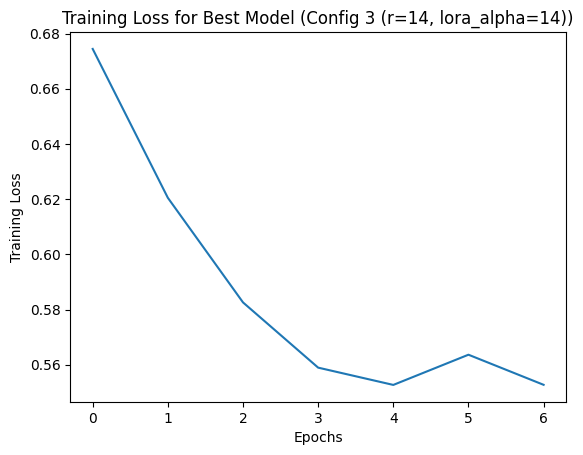

Test Accuracy: 0.6357


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model
from torch.optim.lr_scheduler import LambdaLR

# Loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# WiCDataset
class WiCDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=128):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        sent1, sent2 = sample['sentence1'], sample['sentence2']
        start1, end1 = sample['start1'], sample['end1']
        start2, end2 = sample['start2'], sample['end2']
        label = sample['label']

        # Tokenize the sentence
        enc1 = self.tokenizer(
            sent1,
            return_offsets_mapping=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        enc2 = self.tokenizer(
            sent2,
            return_offsets_mapping=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Extract tokenized input and offsets:
        input_ids1 = enc1["input_ids"][0]
        attention_mask1 = enc1["attention_mask"][0]
        offsets1 = enc1["offset_mapping"][0]
        input_ids2 = enc2["input_ids"][0]
        attention_mask2 = enc2["attention_mask"][0]
        offsets2 = enc2["offset_mapping"][0]

        #  # Generate target masks based on start and end indices
        target_mask1 = find_target_token_indices(start1, end1, offsets1)
        target_mask2 = find_target_token_indices(start2, end2, offsets2)

        return {
            'input_ids1': input_ids1, 'attention_mask1': attention_mask1,
            'input_ids2': input_ids2, 'attention_mask2': attention_mask2,
            'target_mask1': target_mask1, 'target_mask2': target_mask2,
            'label': torch.tensor(label, dtype=torch.long)
        }

def find_target_token_indices(start_idx, end_idx, offset_mapping):
   """
    Returns a mask that identifies the tokens corresponding to the target span.
    """
    mask = torch.zeros(offset_mapping.shape[0], dtype=torch.float)
    for i, (token_start, token_end) in enumerate(offset_mapping):
        token_start = token_start.item()
        token_end = token_end.item()
        if token_start < end_idx and token_end > start_idx:
            mask[i] = 1.0
    return mask

# WiCClassifier with interaction features
class WiCClassifier(nn.Module):
    def __init__(self, bert_model):
        """
        Initializes the classifier using BERT model with an additional classification layer.
        """
        super().__init__()
        self.bert = bert_model
        hidden_size = bert_model.config.hidden_size
        combined_size = hidden_size * 4
        self.classifier = nn.Sequential(
            nn.Linear(combined_size, 512),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(512, 2)
        )

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, target_mask1, target_mask2):
       """
        Forward pass through the BERT model, followed by interaction-based feature extraction.
        """
        output1 = self.bert(input_ids=input_ids1, attention_mask=attention_mask1)
        output2 = self.bert(input_ids=input_ids2, attention_mask=attention_mask2)
        embeddings1 = output1.last_hidden_state
        embeddings2 = output2.last_hidden_state

        # Compute target embedding
        mask1 = target_mask1.unsqueeze(-1)
        mask2 = target_mask2.unsqueeze(-1)
        target_embeds1 = embeddings1 * mask1
        target_embeds2 = embeddings2 * mask2
        sum_embed1 = target_embeds1.sum(dim=1)
        sum_embed2 = target_embeds2.sum(dim=1)
        count1 = mask1.sum(dim=1).clamp(min=1)
        count2 = mask2.sum(dim=1).clamp(min=1)
        target_vec1 = sum_embed1 / count1
        target_vec2 = sum_embed2 / count2

        # Interaction-based features
        mult = target_vec1 * target_vec2
        abs_diff = torch.abs(target_vec1 - target_vec2)
        combined_vec = torch.cat([target_vec1, target_vec2, mult, abs_diff], dim=1)
        logits = self.classifier(combined_vec)
        return logits

# Training configuration
num_epochs = 5
learning_rate = 2e-5
max_length = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device set to use {device}")

# Prepare datasets and dataloaders
train_dataset = WiCDataset(dataset['train'], tokenizer, max_length)
val_dataset = WiCDataset(dataset['validation'], tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Experimenting with different LoRa configurations
def get_model_for_lora_config(lora_config):
    base_bert = AutoModel.from_pretrained('bert-base-uncased')
    bert_model = get_peft_model(base_bert, lora_config)
    model = WiCClassifier(bert_model).to(device)
    return model

# Using 3 different parameters and selecting the best one
lora_configs = [
    LoraConfig(r=10, lora_alpha=16, target_modules=["query", "value"], lora_dropout=0.1, bias="none", task_type="FEATURE_EXTRACTION"),
    LoraConfig(r=12, lora_alpha=15, target_modules=["query", "value"], lora_dropout=0.1, bias="none", task_type="FEATURE_EXTRACTION"),
    LoraConfig(r=14, lora_alpha=14, target_modules=["query", "value"], lora_dropout=0.1, bias="none", task_type="FEATURE_EXTRACTION")
]

best_val_acc = 0
best_config = None
val_accs = []
best_model = None
training_losses = []

# Training loop for each LoRA configuration
for i, lora_config in enumerate(lora_configs):
    print(f"Training with Config {i+1} (r={lora_config.r}, lora_alpha={lora_config.lora_alpha})")

    # Get model for this configuration
    model = get_model_for_lora_config(lora_config)

    # Setting up optimizer, scheduler, and loss criterion
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(total_steps * 0.1)
    scheduler = LambdaLR(optimizer, lr_lambda=lambda step:
        min(1.0, step / warmup_steps) if step < warmup_steps
        else max(0.1, 1 - (step - warmup_steps) / (total_steps - warmup_steps))
    )
    criterion = nn.CrossEntropyLoss()

    # Training and validation loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in progress_bar:
            input_ids1 = batch['input_ids1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            attention_mask1 = batch['attention_mask1'].to(device)
            attention_mask2 = batch['attention_mask2'].to(device)
            target_mask1 = batch['target_mask1'].to(device)
            target_mask2 = batch['target_mask2'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2, target_mask1, target_mask2)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} done! Average training loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids1 = batch['input_ids1'].to(device)
                input_ids2 = batch['input_ids2'].to(device)
                attention_mask1 = batch['attention_mask1'].to(device)
                attention_mask2 = batch['attention_mask2'].to(device)
                target_mask1 = batch['target_mask1'].to(device)
                target_mask2 = batch['target_mask2'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2, target_mask1, target_mask2)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        val_accs.append(val_acc)
        print(f"Validation accuracy for Config {i+1}: {val_acc:.4f}")

        # Track the best configuration based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config = f"Config {i+1} (r={lora_config.r}, lora_alpha={lora_config.lora_alpha})"
            best_model = model  # Save the best model

        # Track the training loss for the best model
        if best_model == model:
            training_losses.append(avg_train_loss)

# Final results
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Configuration: {best_config}")

# Plot training loss for the best model
plt.plot(training_losses)
plt.title(f"Training Loss for Best Model ({best_config})")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

# Testing  the best model on the test set
test_dataset = WiCDataset(dataset['test'], tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=32)

best_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for batch in test_loader:
        input_ids1 = batch['input_ids1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        target_mask1 = batch['target_mask1'].to(device)
        target_mask2 = batch['target_mask2'].to(device)
        labels = batch['label'].to(device)

        outputs = best_model(input_ids1, attention_mask1, input_ids2, attention_mask2, target_mask1, target_mask2)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")  # Print test accuracy up to 4 decimals


# Submission

Congratulations! You finished the assignment & you're ready to submit your work. Please follow the instructions:

1. Check and review your answers. Make sure all of the cell outputs are what you want.
2. Select File > Save.
3. **Fill your information** & run the cell bellow.
4. Run **Make Submission** cell, It may take several minutes and it may ask you for your credential.
5. Run **Download Submission** cell to obtain your submission as a zip file.
6. Grab the downloaded file (`dl_asg01__xx__xx.zip`) and hand it over.

## Fill your information (Run the cell)

In [ ]:
#@title Enter your information & "RUN the cell!!" { run: "auto" }
student_id = "C24082638" #@param {type:"string"}
student_name = "Rehaan Shaikh " #@param {type:"string"}

print("your student id:", student_id)
print("your name:", student_name)


from pathlib import Path

ASSIGNMENT_PATH = Path('asg01')
ASSIGNMENT_PATH.mkdir(parents=True, exist_ok=True)

your student id: C24082638
your name: Rehaan Shaikh 


## Make Submission (Run the cell)

In [ ]:
#@title Make submission
! pip install -U --quiet PyDrive > /dev/null
! pip install -U --quiet jdatetime > /dev/null
! apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc > /dev/null

import os
import time
import yaml
import json
import jdatetime

from google.colab import files
from IPython.display import Javascript
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

asg_name = 'WiC_Finetuning'
script_save = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''

submission_file_name = 'dl_asg01__%s__%s.zip'%(student_id, student_name.lower().replace(' ',  '_'))

sub_info = {
    'student_id': student_id,
    'student_name': student_name,
    'dateime': str(jdatetime.date.today()),
    'asg_name': asg_name
}
json.dump(sub_info, open('info.json', 'w'))

Javascript(script_save)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = drive.ListFile({'q':"title='%s.ipynb'"%asg_name}).GetList()[0]['id']
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('%s.ipynb'%asg_name)

! jupyter nbconvert --to script "$asg_name".ipynb > /dev/null
! jupyter nbconvert --to pdf "$asg_name".ipynb > /dev/null

! zip "$submission_file_name" "$asg_name".ipynb "$asg_name".html "$asg_name".txt info.json > /dev/null

print("##########################################")
print("Done! Submisson created, Please download using the bellow cell!")

Extracting templates from packages: 100%


[NbConvertApp] Converting notebook WiC_Finetuning.ipynb to script
[NbConvertApp] Writing 11218 bytes to WiC_Finetuning.txt
[NbConvertApp] Converting notebook WiC_Finetuning.ipynb to pdf
[NbConvertApp] Writing 72553 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 83950 bytes to WiC_Finetuning.pdf
##########################################
Done! Submisson created, Please download using the bellow cell!


In [ ]:
drive.ListFile({'q':"title='%s.ipynb'"%asg_name}).GetList()[0]['id']

'1gakoqGs5WLPGglk95qmrVIWoNZfIOwvN'

In [ ]:
files.download(submission_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>